In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys

In [2]:
PROJECT_ROOT = os.path.dirname(os.getcwd())
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)

In [3]:
import src.metrics as metrics

In [4]:
COUNTRIES = ['DE', 'FR', 'ES']
SPLITS = ['dev', 'test']
DATA_DIR = os.path.join(PROJECT_ROOT, 'data')
OUTPUT_DIR = os.path.join(PROJECT_ROOT, 'outputs')

print("Metrics library imported successfully.")

Metrics library imported successfully.


In [5]:
all_results = []

for country in COUNTRIES:
    print(f"--- Evaluating {country} ---")

    # 1. Load the original series to get the training data
    orig_file_path = os.path.join(DATA_DIR, f"{country}.csv")
    df_orig = pd.read_csv(orig_file_path, parse_dates=['timestamp'], index_col='timestamp')

    # Define the training set (first 80%) for MASE calculation
    train_end_idx = int(len(df_orig) * 0.8)
    train_series = df_orig['load'].iloc[:train_end_idx]

    for split in SPLITS:
        # 2. Load the forecast file from Day 4
        forecast_file = os.path.join(OUTPUT_DIR, f"{country}_forecasts_{split}.csv")
        try:
            df_forecast = pd.read_csv(forecast_file)
        except FileNotFoundError:
            print(f"File not found: {forecast_file}. Skipping.")
            continue

        # 3. Extract the columns
        y_true = df_forecast['y_true']
        y_pred = df_forecast['yhat']
        lo = df_forecast['lo']
        hi = df_forecast['hi']

        # 4. Calculate all metrics
        scores = {
            'country': country,
            'split': split,
            'MASE': metrics.calculate_mase(y_true, y_pred, train_series, seasonality=24),
            'sMAPE': metrics.calculate_smape(y_true, y_pred),
            'RMSE': metrics.calculate_rmse(y_true, y_pred),
            'MAPE': metrics.calculate_mape(y_true, y_pred),
            'MSE': metrics.calculate_mse(y_true, y_pred),
            'Coverage (80%)': metrics.calculate_coverage(y_true, lo, hi)
        }
        all_results.append(scores)

print("All evaluations complete.")

--- Evaluating DE ---
--- Evaluating FR ---
--- Evaluating ES ---
All evaluations complete.


In [6]:
df_results = pd.DataFrame(all_results)

In [7]:
cols_order = ['country', 'split', 'MASE', 'sMAPE', 'RMSE', 'MAPE', 'MSE', 'Coverage (80%)']
df_results = df_results[cols_order]

In [8]:
save_path = os.path.join(OUTPUT_DIR, 'metrics_summary.csv')
df_results.to_csv(save_path, index=False)
print(f"Saved metrics summary to {save_path}.")

Saved metrics summary to /Users/pavanmandapaka/Documents/opsd-power-desk/outputs/metrics_summary.csv.


In [9]:
print(" Final Metrics Summary ")
print(df_results.to_string())

 Final Metrics Summary 
  country split      MASE     sMAPE         RMSE      MAPE           MSE  Coverage (80%)
0      DE   dev  0.349152  2.474463  1757.032838  2.505742  3.087164e+06      100.000000
1      DE  test  0.274915  1.951041  1645.407081  1.928132  2.707364e+06       98.958333
2      FR   dev  0.960666  4.277174  3741.563495  4.434974  1.399930e+07       85.763889
3      FR  test  0.288118  1.411684  1159.558562  1.408679  1.344576e+06       65.277778
4      ES   dev  0.521035  3.252703  1305.578794  3.311332  1.704536e+06       97.569444
5      ES  test  0.276179  1.546378   690.517253  1.530466  4.768141e+05      100.000000


In [10]:
df_test= df_results[df_results['split']=='test']


Saved comparison plot to /Users/pavanmandapaka/Documents/opsd-power-desk/outputs/test_mase_comparison.png


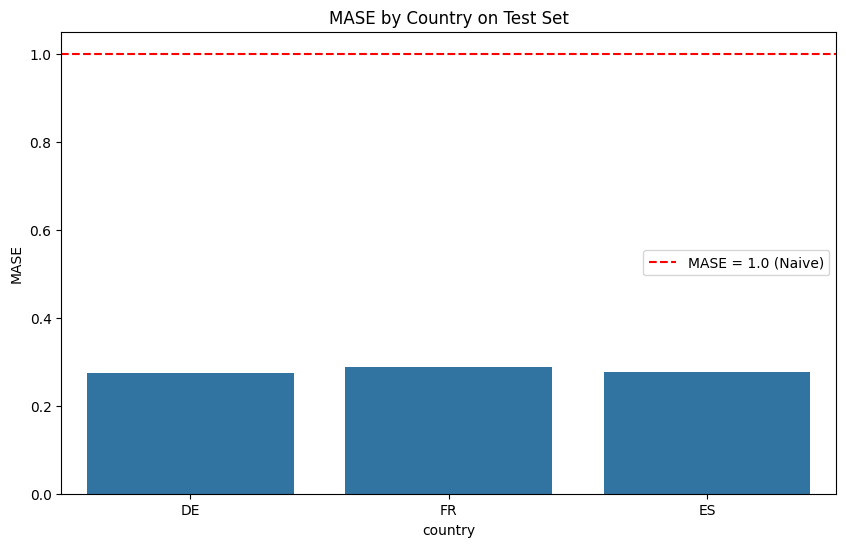

In [13]:
plt.figure(figsize=(10, 6))
sns.barplot(data=df_test, x='country', y='MASE')
plt.axhline(y=1, color ='red', linestyle='--', label='MASE = 1.0 (Naive)')
plt.title('MASE by Country on Test Set')
plt.legend()

plot_path = os.path.join(OUTPUT_DIR, 'test_mase_comparison.png')
plt.savefig(plot_path)
print(f"Saved comparison plot to {plot_path}")